In [1]:
from pathlib import Path

import os
import torch
import albumentations as A

from tracenet.datasets import FilamentDetection
from tracenet import get_train_transform, get_valid_transform, collate_fn
from tracenet.utils.plot import plot_results
from tracenet.models.detr import build_model

In [2]:
data = 'mt'
data_dir = 'mtdata_real'
model_path = rf'model_test_mt_real/swept-river-19/best_model.pth'
maxsize = 370

train_dir = 'train'
val_dir = 'val'
bs = 4
n_points = 2

In [3]:
path = Path(data_dir)

ds = []
for dset, transform in zip([train_dir, val_dir], [get_train_transform, get_valid_transform]): 
    files = os.listdir(path / dset / 'img')
    files.sort()
    ds.append(
        FilamentDetection(
            [path / dset / 'img' / fn for fn in files],
            [path / dset / 'gt' / fn.replace('.tif', '.csv') for fn in files],
            transforms=transform(keypoint_params=A.KeypointParams(format='xy', 
                                                                  label_fields=['point_labels'], 
                                                                  remove_invisible=False, 
                                                                  angle_in_degrees=True)),
            maxsize=maxsize, n_points=n_points
        )
    )
ds_train, ds_val = ds

dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, 
                                       collate_fn=collate_fn,
                                       batch_size=bs, num_workers=bs)
dl_val = torch.utils.data.DataLoader(ds_val, shuffle=False, 
                                     collate_fn=collate_fn,
                                     batch_size=bs, num_workers=bs)

In [4]:
imgs, targets = next(iter(dl_train))

/research/sharedresources/cbi/common/Anna/codes/trace-net/tracenet/datasets/filament.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  boxes = torch.as_tensor(boxes, dtype=torch.float32)
/research/sharedresources/cbi/common/Anna/codes/trace-net/tracenet/datasets/filament.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  boxes = torch.as_tensor(boxes, dtype=torch.float32)
/research/sharedresources/cbi/common/Anna/codes/trace-net/tracenet/datasets/filament.py:37: UserWarn

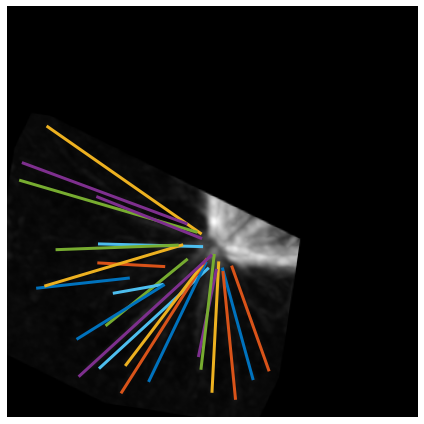

In [5]:
ind = 1
img_gt = plot_results(imgs[ind], targets[ind]['boxes'], return_image=True)

## Prediction

In [6]:
model = build_model(n_classes=1, n_points=n_points, 
                    pretrained=True, 
                    state_dict_path=model_path
                   ).eval();

Using cache found in /home/amedyukh/.cache/torch/hub/facebookresearch_detr_main


/home/amedyukh/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


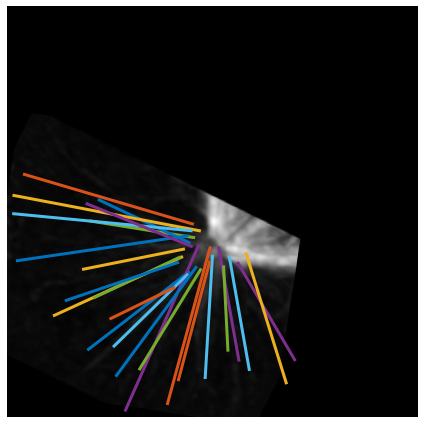

In [7]:
# propagate through the model
with torch.no_grad():
    outputs = model(imgs)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[ind, :, :-1]
keep = probas.max(-1).values > 0.9
img_model = plot_results(imgs[ind], outputs['pred_boxes'][ind, keep], return_image=True)

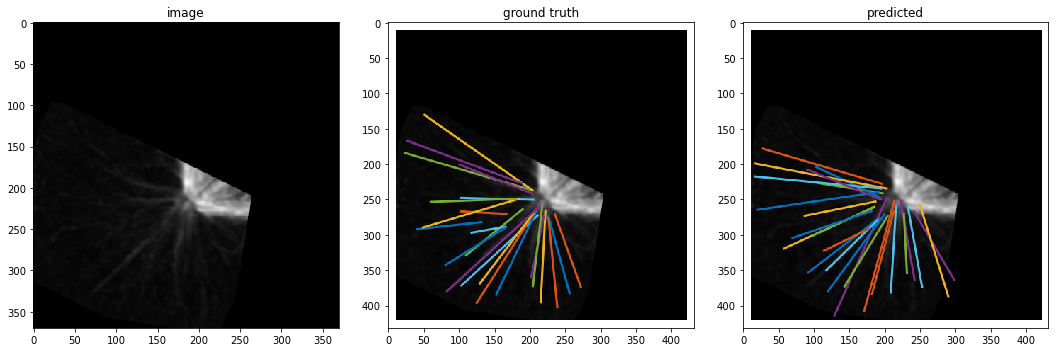

In [8]:
import pylab as plt
from skimage import io
fig, ax = plt.subplots(1, 3, figsize=(15,5))
titles = ['image', 'ground truth', 'predicted']
for i, im, in enumerate([imgs[ind].numpy().transpose(1,2,0), img_gt, img_model]):
    plt.sca(ax[i])
    plt.title(titles[i])
    s = int(0.6*im.shape[0])
    io.imshow(im)
plt.savefig('TRaceNet_real_data_train.png')

## Test the Loss

In [9]:
from tracenet.models.matcher import HungarianMatcher
from tracenet.models.criterion import Criterion

In [10]:
matcher = HungarianMatcher()

In [11]:
indices = matcher(outputs, targets)

In [12]:
loss = Criterion(1, matcher, 
                 losses=['labels', 'boxes', 'cardinality'])

In [13]:
loss(outputs, targets)

{'loss_ce': tensor(0.0377),
 'loss_bbox': tensor(0.0981),
 'cardinality_error': tensor(2.2500)}

In [14]:
indices[ind]

(tensor([ 0,  2,  7, 11, 22, 23, 26, 29, 30, 44, 48, 55, 56, 67, 69, 76, 77, 79,
         80, 82, 84, 86, 96]),
 tensor([ 9,  6, 22,  7, 17,  2, 19, 15, 14,  8, 16,  4, 20,  1,  3, 10,  5, 11,
         13, 21, 12,  0, 18]))

In [15]:
for ind1, ind2 in zip(*indices[ind]):
    print(outputs['pred_boxes'][ind][ind1], targets[ind]['boxes'][ind2], probas[ind1])

tensor([0.3186, 0.7403, 0.3152, 0.2088]) tensor([0.3351, 0.7524, 0.4402, 0.2359]) tensor([0.9967])
tensor([0.4411, 0.7766, 0.4004, 0.4152]) tensor([0.4135, 0.7672, 0.3249, 0.3573]) tensor([0.9989])
tensor([0.3064, 0.6146, 0.2556, 0.0629]) tensor([0.2664, 0.5859, 0.3000, 0.0119]) tensor([0.9923])
tensor([0.3758, 0.7821, 0.4455, 0.3671]) tensor([0.3805, 0.7771, 0.3897, 0.3195]) tensor([0.9991])
tensor([0.3279, 0.5418, 0.2606, 0.9496]) tensor([0.3479, 0.5807, 0.2561, 0.9917]) tensor([0.9925])
tensor([0.4899, 0.7553, 0.3029, 0.4811]) tensor([0.5058, 0.7801, 0.3206, 0.4836]) tensor([0.9980])
tensor([0.3324, 0.5223, 0.2496, 0.8591]) tensor([0.3009, 0.6281, 0.1657, 0.9825]) tensor([0.9963])
tensor([0.2453, 0.4683, 0.4339, 0.9088]) tensor([0.2362, 0.4541, 0.4304, 0.8869]) tensor([0.9859])
tensor([0.2410, 0.5023, 0.4671, 0.9402]) tensor([0.2835, 0.4217, 0.4605, 0.8062]) tensor([0.9779])
tensor([0.3956, 0.7611, 0.2907, 0.3250]) tensor([0.3804, 0.7511, 0.3108, 0.2926]) tensor([0.9969])
tensor([0.